# 2. MFA for PostMLF: with Positive AND Negative Mode, All Features

In [10]:
import pandas as pd
import numpy as np
import os
import openpyxl

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import combinations
from sklearn.decomposition import PCA
from scipy.stats import zscore, entropy, f_oneway, kruskal
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.cross_decomposition import CCA
import prince


from sklearn.ensemble import IsolationForest

%matplotlib inline

In [11]:
# set the directory 
os.chdir('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/Results')

In [12]:
# Define the color palette for the sample types
sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

group_colors = {'Climate': '#482677FF', 'Wine Chemistry': '#2D718EFF', 'Plots': '#3CBC75FF', 'Metabolites_Pos':'#FDE725FF', 'Metabolites_Neg':'#DCE318FF'}

In [13]:
df_wMetadata_cleaned_collapsed = pd.read_csv('Pos_MS2_OutlierRemoved.csv', index_col=0)
postMLF_df_Pos = df_wMetadata_cleaned_collapsed[df_wMetadata_cleaned_collapsed['sample_type'] == 'PostMLF'].reset_index()
postMLF_df_Pos.shape

(31, 195)

In [14]:
df_wMetadata_cleaned_collapsed = pd.read_csv('Neg_MS2_OutlierRemoved.csv', index_col=0)
postMLF_df_Neg = df_wMetadata_cleaned_collapsed[df_wMetadata_cleaned_collapsed['sample_type'] == 'PostMLF'].reset_index()
postMLF_df_Neg.shape

(31, 174)

In [15]:
postMLF_df_reset = pd.merge(postMLF_df_Pos, postMLF_df_Neg, on=('Sample Name', 'sample_type', 'year', 'plot'), how='outer')
postMLF_df_reset.shape

(31, 365)

In [16]:
#### 1. MERGE ALL 

# CHEMISTRY
md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/Raw-MD_Vineyard_MV_data.csv')
md["Plot_str"] = "Plot" + md["Plot"].astype(str)
md_wine_chemistry = md[['Plot_str', 'Year', 'Must_Oechsle', 'Wine_Tartatic_Acid', 
                        'Wine_Malic_Acid', 'Wine_Glucose', 'Wine_Fructose', 
                        'Wine_Lactic_Acid', 'Wien_Glycerol', 'Wine_Acetic_Acid']]

df_merged = postMLF_df_reset.merge(md_wine_chemistry, left_on=["plot", "year"], right_on=["Plot_str", "Year"], how="inner")
df_merged = df_merged.drop(columns=['Plot_str', 'Year', 'sample_type'])


# PLOTS
md_plots = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/RawMD-Lavaux_plots.csv')
md_plots["Plot_str"] = "Plot" + md_plots["Plot"].astype(str)
md_plots_subset =  md_plots[['Plot_str', 'Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'Geology', 'Hydromorphie_code']]
# Convert categorical columns to dummy variables
categorical_cols = ['Exposition', 'Geology']
md_plots_subset_dummies = pd.get_dummies(md_plots_subset, columns=categorical_cols, drop_first=True)
# Convert boolean columns to integers (0 or 1)
boolean_columns = md_plots_subset_dummies.select_dtypes(include='bool').columns
md_plots_subset_dummies[boolean_columns] = md_plots_subset_dummies[boolean_columns].astype(int)

df_merged = df_merged.merge(md_plots_subset_dummies, left_on=["plot"], right_on=["Plot_str"], how="inner")
df_merged = df_merged.drop(columns=['Plot_str'])


# CLIMATE
md_climate = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/RawMD-Lavaux-Climate.csv', index_col=0)
# Remove underscores from the 'Plot' column
md_climate['Plot'] = md_climate['Plot'].str.replace('_', '', regex=False)
# include more climate data 
md_climate_subset = md_climate[['Plot', 'Year', 'cv_rh', 'average_rh', 'cv_temperature', 'accumulated_temperature', 'average_temperature']]
# minimum 
#md_climate_subset = md_climate[['Plot', 'Year',  'average_rh','average_temperature']]

df_merged_all = df_merged.merge(md_climate_subset, left_on=["plot", "year"], right_on=["Plot", "Year"], how="inner")
df_merged_all = df_merged_all.drop(columns=['Plot', 'Year'])
df_merged_all = df_merged_all.dropna()


# Keep track of the columns' origins
metabolites_Neg_columns = postMLF_df_Neg.iloc[:, 4:].columns.tolist()
metabolites_Pos_columns = postMLF_df_Pos.iloc[:, 4:].columns.tolist()
wine_chemistry_columns = md_wine_chemistry.iloc[:, 2:].columns.tolist()
plots_columns = md_plots_subset_dummies.iloc[:, 1:].columns.tolist()
climate_columns = md_climate_subset.iloc[:, 2:].columns.tolist()
metadata_columns = ['Sample Name', 'year', 'plot']

df_merged_all.head()

,Sample Name,year,plot,"1,2-Di-(9Z,12Z,15Z-octadecatrienoyl)-sn-glycero-3-phosphocholine","1,2-Dilinoleoyl-sn-glycero-3-phosphocholine","1,2-Dipalmitoleoyl-sn-glycero-3-phosphocholine","1,5-Naphthalenediamine","1,6-ANHYDRO-B-GLUCOSE","1-(3,4-dimethoxyphenyl)ethan-1-one oxime",1-Palmitoyl-sn-glycero-3-phosphocholine,...,Hydromorphie_code,Exposition_South-West,Geology_Colluvium,Geology_Gravel_moraine,Geology_Molasse,cv_rh,average_rh,cv_temperature,accumulated_temperature,average_temperature
0,PostMLF_2021_Plot11,2021,Plot11,-0.585963,-0.474270,-0.532204,-0.538732,-0.766243,0.481209,-0.652926,...,1,0,0,1,0,16.118351,71.948958,23.246939,2910.232671,17.964399
1,PostMLF_2021_Plot13,2021,Plot13,-0.653453,-0.508855,-0.621821,-0.575688,-0.856514,0.761038,-0.681777,...,1,1,0,0,1,15.751161,71.334895,23.908978,2842.227212,17.544612
2,PostMLF_2021_Plot14,2021,Plot14,-0.412632,-0.527166,-0.546934,-0.359954,-0.550805,0.658860,-0.301487,...,1,0,0,0,0,15.496785,70.767447,22.570476,2971.667531,18.343627
3,PostMLF_2021_Plot15,2021,Plot15,-0.502183,-0.464256,-0.531862,-0.438669,-0.606908,0.887332,-0.452500,...,0,1,0,1,0,16.546105,72.104023,23.283449,2898.619538,17.892713
4,PostMLF_2021_Plot17,2021,Plot17,-0.590367,-0.503435,-0.598670,-0.443338,-0.699624,0.793923,-0.430528,...,1,1,0,0,1,16.381958,72.076768,21.847832,2993.198664,18.476535


In [17]:
# Create a multi-index column structure
multi_index_columns = (
    [('Metabolites_Pos', col) for col in metabolites_Pos_columns] +
    [('Metabolites_Neg', col) for col in metabolites_Neg_columns] +
    [('Wine Chemistry', col) for col in wine_chemistry_columns] +
    [('Plots', col) for col in plots_columns] +
    [('Climate', col) for col in climate_columns]
)

# Subset data and assign multi-index
df_metadata = df_merged_all[metadata_columns]  # Keep metadata separately
df_mfa = df_merged_all.drop(columns=metadata_columns)  # Drop metadata
df_mfa.columns = pd.MultiIndex.from_tuples(multi_index_columns)  # Assign multi-index

# Extract the group names (first level of multi-index)
groups = df_mfa.columns.levels[0].tolist()

df_mfa.shape

(28, 382)

In [18]:
# drop columns with zero variance 
zero_var_cols = df_mfa.std() == 0
df_mfa = df_mfa.loc[:, ~zero_var_cols]

df_mfa.shape

(28, 382)

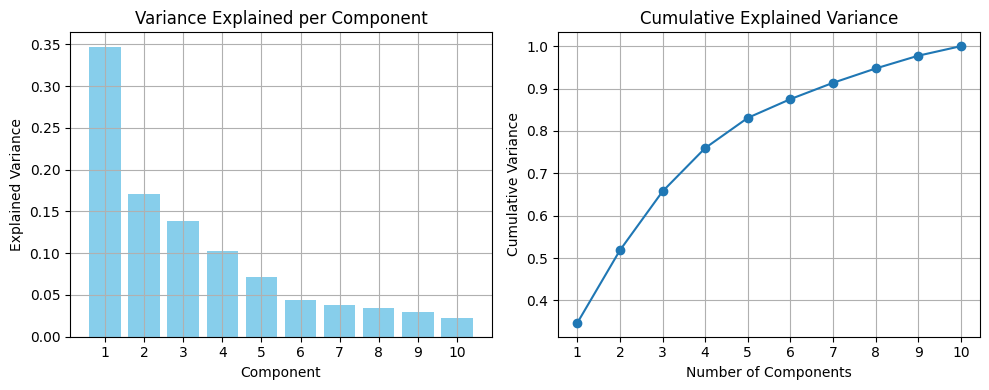

In [19]:
# Define the number of components to test
n_components = 10

# Define MFA and fit the model
mfa = prince.MFA(
    n_components=n_components,  # Use 10 components
    n_iter=3, 
    copy=True,
    check_input=True,
    random_state=42)

# Fit MFA to the data (excluding metadata columns)
mfa = mfa.fit(
    df_mfa,
    groups=groups,
    supplementary_groups=None)

# Get explained variance per component
explained_variance_ratio = mfa.eigenvalues_ / np.sum(mfa.eigenvalues_)

# Create subplots for explained variance and cumulative variance plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar plot for variance explained per component
axes[0].bar(range(1, n_components + 1), explained_variance_ratio[:n_components], color='skyblue')
axes[0].set_title('Variance Explained per Component')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Explained Variance')
axes[0].set_xticks(range(1, n_components + 1))
axes[0].grid(True)

# Line plot for cumulative explained variance (elbow plot)
axes[1].plot(range(1, n_components + 1), np.cumsum(explained_variance_ratio[:n_components]), marker='o', linestyle='-')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_xticks(range(1, n_components + 1))
axes[1].grid(True)

# Adjust layout to ensure proper display
plt.tight_layout()
plt.show()

In [20]:
# Initialize MFA model
mfa = prince.MFA(
    n_components=5,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

# Fit MFA with multi-index groups
mfa = mfa.fit(
    df_mfa,
    groups=groups,
    supplementary_groups=None)

mfa_results = mfa.transform(df_mfa)
# Merge MFA results with metadata to retain 'year' information
mfa_results = mfa_results.merge(df_metadata, left_index=True, right_index=True)

mfa.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,3.574,29.62%,29.62%
1,1.765,14.63%,44.25%
2,1.430,11.85%,56.10%
3,1.053,8.73%,64.82%
4,0.734,6.08%,70.90%


In [32]:
df_group

,Group,Sum of Contributions
0,Climate,137.766299
1,Metabolites_Neg,179.215172
2,Metabolites_Pos,131.466031
3,Plots,295.666363
4,Wine Chemistry,166.078955


/scratch/lfloerl/tmpdata/ipykernel_2768468/2780526499.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y='Sum of Contributions', data=df_group, palette='viridis')


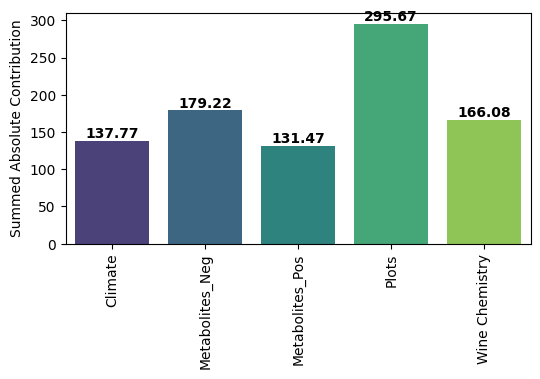

In [36]:
partial_coords = mfa.partial_row_coordinates(df_mfa)

# Assuming `partial_coords` is the dataframe you obtained from MFA
df_abs_sum = partial_coords.abs().sum()

# Convert to DataFrame for plotting
df_group = df_abs_sum.groupby(level=0).sum().reset_index()
df_group.columns = ['Group', 'Sum of Contributions']

# Plot
plt.figure(figsize=(6, 3))
ax = sns.barplot(x='Group', y='Sum of Contributions', data=df_group, palette='viridis')
# Add numeric values on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Summed Absolute Contribution')
plt.show()

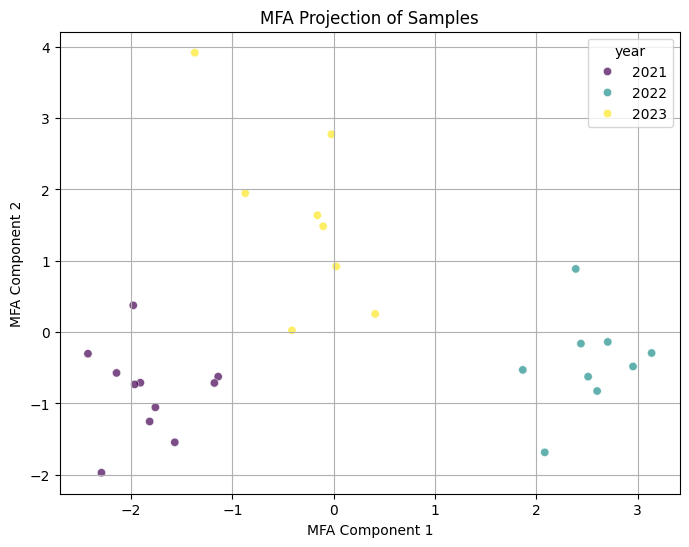

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], hue="year", palette="viridis", alpha=0.7)
plt.xlabel("MFA Component 1")
plt.ylabel("MFA Component 2")
plt.title("MFA Projection of Samples")
plt.grid()
plt.show()

In [23]:
# Extract coordinates of individuals (rows)
individuals = mfa_results.iloc[:, :2].values  # First 2 components

# Extract variable loadings (correlations with MFA axes)
variable_loadings = mfa.column_correlations.iloc[:, :2]

# Drop the multi-index
variable_loadings_df = variable_loadings.reset_index()

# Rename columns
variable_loadings_df.columns = ["Variable", "MFA Comp 1", "MFA Comp 2"]

# Compute Loadings contribution (sum of squared correlations)
variable_loadings_df["Loadings Contribution"] = ( variable_loadings_df["MFA Comp 1"].abs() + variable_loadings_df["MFA Comp 2"].abs())

# Sort by Loadings contribution in descending order
variable_loadings_df = variable_loadings_df.sort_values(by="Loadings Contribution", ascending=False)

variable_loadings_df.head()

,Variable,MFA Comp 1,MFA Comp 2,Loadings Contribution
43,"(Metabolites_Neg, Azelaic acid)",0.674024,-0.613697,1.287721
197,"(Metabolites_Pos, 4-Methyl-5-thiazoleethanol)",-0.744199,-0.538807,1.283006
284,"(Metabolites_Pos, N1-[4-(1,3-Oxazol-5-yl)pheny...",-0.742931,-0.526168,1.269098
377,"(Wine Chemistry, Wine_Glucose)",-0.465583,0.798135,1.263718
226,"(Metabolites_Pos, Galangin)",-0.744239,-0.510238,1.254477


In [24]:
# Extract the first element of the tuple as the 'group'
variable_loadings_df["group"] = variable_loadings_df["Variable"].apply(lambda x: x[0])

# Filter out 'Metabolites'
filtered_loadings_df = variable_loadings_df[
    (variable_loadings_df["group"] != "Metabolites_Neg") & 
    (variable_loadings_df["group"] != "Metabolites_Pos")]

# Select top 20 based on Loadings Contribution
top_loadings = filtered_loadings_df.nlargest(15, "Loadings Contribution")
top_loadings['Variable'] = top_loadings['Variable'].astype(str).str.split(',').str[1].str.strip(')')

top_loadings

,Variable,MFA Comp 1,MFA Comp 2,Loadings Contribution,group
377,'Wine_Glucose',-0.465583,0.798135,1.263718,Wine Chemistry
3,'accumulated_temperature',0.861129,0.391211,1.252340,Climate
376,'Wine_Malic_Acid',-0.452332,0.718015,1.170347,Wine Chemistry
1,'average_rh',-0.916682,-0.209995,1.126677,Climate
379,'Wine_Lactic_Acid',-0.878477,-0.234074,1.112551,Wine Chemistry
4,'average_temperature',0.593879,0.504970,1.098848,Climate
2,'cv_temperature',0.627830,0.438010,1.065841,Climate
381,'Wine_Acetic_Acid',-0.472465,0.568228,1.040693,Wine Chemistry
375,'Wine_Tartatic_Acid',-0.910760,-0.122964,1.033725,Wine Chemistry
380,'Wien_Glycerol',-0.865306,-0.162097,1.027403,Wine Chemistry


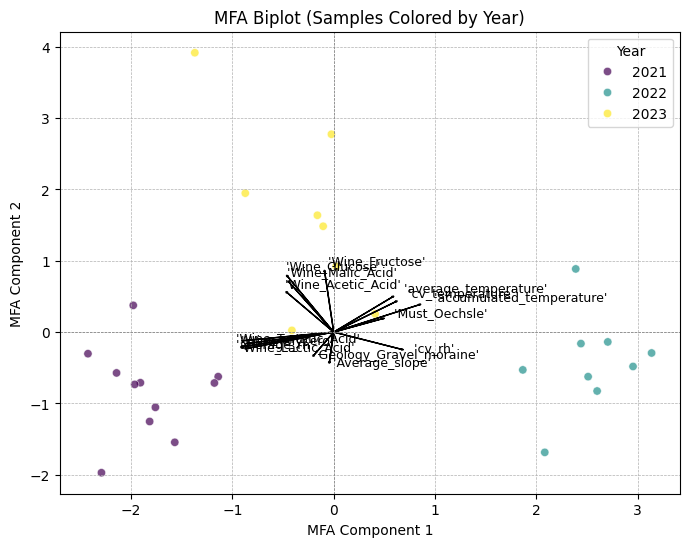

In [25]:
# Biplot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot of individuals, colored by year
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], hue="year", palette="viridis", alpha=0.7)


# Define a scaling factor to extend the arrows
scaling_factor = 1 # Adjust this value to control arrow length
# Plot the top loadings as arrows
for i, row in top_loadings.iterrows():
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, 
             head_width=0.02, head_length=0.02, color="black", length_includes_head=True)
    
    ax.text(row["MFA Comp 1"] * (scaling_factor + 0.1),  # Adjust text position accordingly
            row["MFA Comp 2"] * (scaling_factor + 0.1), 
            row["Variable"], fontsize=9)


# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
ax.set_title("MFA Biplot (Samples Colored by Year)")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.legend(title="Year", bbox_to_anchor=(1, 1))

plt.show()

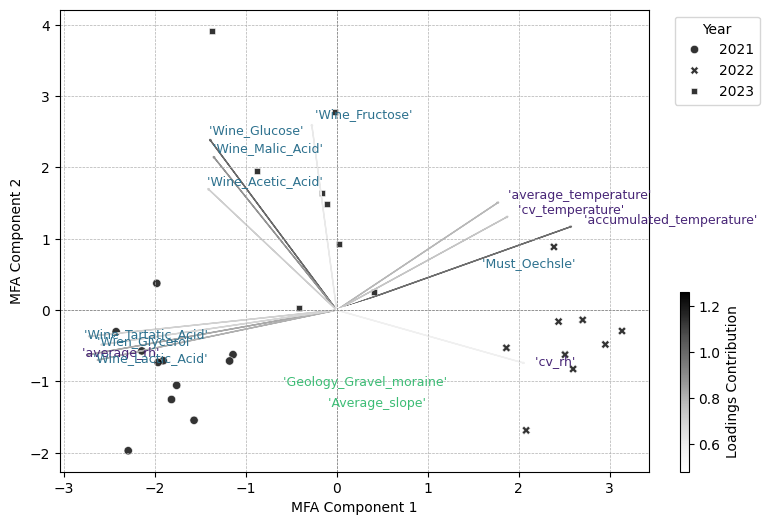

In [26]:
# Biplot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot of individuals, colored by year
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], style="year", alpha=0.8, color='black')

# Define a scaling factor to extend the arrows
scaling_factor = 3  # Adjust this value to control arrow length

# Create a color map based on the group and intensity (Total Contribution)
group_colors = {'Climate': '#482677FF', 'Wine Chemistry': '#2D718EFF', 'Plots': '#3CBC75FF'}  # Define custom colors for each group
norm = plt.Normalize(vmin=top_loadings['Loadings Contribution'].min(), vmax=top_loadings['Loadings Contribution'].max())  # Normalize based on Loadings Contribution
sm = plt.cm.ScalarMappable(cmap='Greys', norm=norm)
sm.set_array([])

# Plot the top loadings as arrows with colors based on the group and intensity by Total Contribution
for i, row in top_loadings.iterrows():
    # Color based on group
    group_color = group_colors.get(row['group'], 'black')  # Default to black if group is not found
    # Scale the arrow by Loadings Contribution
    intensity = norm(row['Loadings Contribution'])
    
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, 
             head_width=0.02, head_length=0.02, color=sm.to_rgba(intensity), length_includes_head=True)
    
    ax.text(row["MFA Comp 1"] * (scaling_factor + 0.1),  # Adjust text position accordingly
            row["MFA Comp 2"] * (scaling_factor + 0.1), 
            row["Variable"], fontsize=9, color=group_color)

# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
ax.set_title("")

# Add colorbar for Loadings Contribution intensity
cbar = fig.colorbar(sm, ax=ax, fraction=0.01, pad=0.04, location='right')
cbar.ax.set_position([0.9, 0.11, 0.7, 0.3]) 
cbar.set_label("Loadings Contribution")

# Show grid and legend
ax.grid(True, linestyle="--", linewidth=0.5)
ax.legend(title="Year", bbox_to_anchor=(1.2, 1))

plt.show()
